#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 06
**CH06A Comparing Online and Offline Prices: Testing the Difference**

billion-prices dataset dataset

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/billion-prices/clean/"
data_out = dirname + "da_case_studies/ch06-online-offline-price-test/"
output = dirname + "da_case_studies/ch06-online-offline-price-test/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
import py_helper_functions as da
sns.set_theme(rc=da.da_theme, palette=da.color)


In [4]:
data = pd.read_csv(data_in + "online_offline_ALL_clean.csv", encoding="latin1")
# data = pd.read_csv("https://osf.io/yhbr5/download", encoding="latin1")


In [5]:
# FILTER DATA
data = data.loc[
 (data["COUNTRY"] == "USA")
    & (data["PRICETYPE"] == "Regular Price")
    & (data["sale_online"].isnull())
    & (data["price"].notna())
    & (data["price_online"].notna())
]


In [6]:
# Drop obvious errors
data = data.loc[data["price"] < 1000]


In [7]:
# Compare variables
data["diff"] = data["price_online"] - data["price"]
descr = data["diff"].describe()


In [8]:
descr


count    6439.000000
mean        0.054460
std         9.994452
min      -380.130000
25%        -0.040000
50%         0.000000
75%         0.000000
max       415.270000
Name: diff, dtype: float64

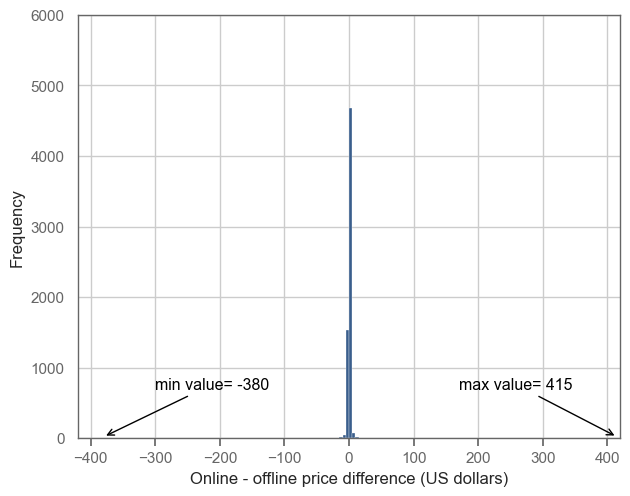

In [9]:
sns.histplot(
    data['diff'], 
    binwidth=5, 
    binrange=(-380,415),
    color=da.color[0], 
    alpha=1
)


plt.xlabel("Online - offline price difference (US dollars)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(-420, 420)
plt.xticks(np.arange(-400, 421, 100))
plt.ylim(0, 6000)
plt.yticks(np.arange(0, 6001, 1000))


plt.annotate(
    "max value= 415", 
    xy=(415, 20), 
    xytext=(170, 700), 
    arrowprops=dict(color='black', arrowstyle='->'),
    fontsize=11.5
)
plt.annotate(
    "min value= -380", 
    xy=(-380, 20), 
    xytext=(-300, 700), 
    arrowprops=dict(color='black', arrowstyle='->'),
    fontsize=11.5
)
plt.show()

In [10]:
# 4.99999 not 5 -- needed because of data imported from stata may be stored wierdly.
data1 = data.loc[abs(data["diff"]) < 4.999999]
data1["diff"].describe()


count    6200.000000
mean       -0.127437
std         0.788358
min        -4.900000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.990000
Name: diff, dtype: float64

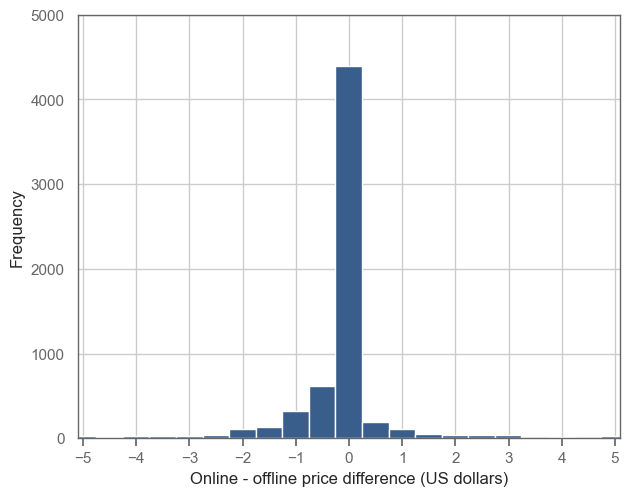

In [11]:
sns.histplot(
    data['diff'], 
    binwidth=0.5, 
    binrange=(-5.25, 5.74),  
    color=da.color[0], 
    edgecolor='white', 
    alpha=1
)


plt.xlabel("Online - offline price difference (US dollars)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(-5.1, 5.1)
plt.xticks(np.arange(-5, 6, 1))
plt.ylim(0, 5000)
plt.yticks(np.arange(0, 5001, 1000))

plt.show()

In [12]:
# HYPOTHESIS
from scipy import stats

stats.ttest_1samp(data["diff"], 0)


TtestResult(statistic=0.4372481266029261, pvalue=0.6619460766193054, df=6438)

In [13]:
def t_test_1samp(series, mu=0):
    """
    This is a function to calculate t_test for 1 sample.
    Return: tuple of 2 elements, first is sample mean, second is t test object from scipy
    """
    return (np.mean(series), stats.ttest_1samp(series, mu))


In [14]:
# MULTIPLE HYPOTHESES
spd = [data.loc[data["retailer"] == x] for x in set(data["retailer"])]
out = [(set(x["retailer"]), t_test_1samp(x["diff"], 0)) for x in spd]

In [15]:
out


[({44},
  (3.73675,
   TtestResult(statistic=2.0970967695735117, pvalue=0.038102345149389, df=119))),
 ({45},
  (-1.2166300366300367,
   TtestResult(statistic=-1.2271928388565805, pvalue=0.22027995382690432, df=545))),
 ({46},
  (-0.4290707648320227,
   TtestResult(statistic=-11.641716539786147, pvalue=5.8008651517374406e-30, df=1398))),
 ({47},
  (0.051625239005736144,
   TtestResult(statistic=1.6613855468290473, pvalue=0.09723645884012402, df=522))),
 ({48},
  (0.42059701492537316,
   TtestResult(statistic=2.132197897818741, pvalue=0.033903290670897486, df=267))),
 ({49},
  (2.410042735042735,
   TtestResult(statistic=1.2798236568799926, pvalue=0.20187999009028343, df=233))),
 ({50},
  (0.606011673151751,
   TtestResult(statistic=1.6405334895253019, pvalue=0.10150724842940251, df=513))),
 ({51},
  (0.28394321766561514,
   TtestResult(statistic=1.8754817018086298, pvalue=0.061648393463910545, df=316))),
 ({53},
  (-0.9704273504273504,
   TtestResult(statistic=-2.7305459292926293, pval

In [16]:
table_out = pd.DataFrame.from_records(
    [
        {"retailer": list(x[0])[0], "estimate": x[1][0], "p.value": x[1][1].pvalue}
        for x in out
    ]
)

In [17]:
table_out


,retailer,estimate,p.value
0,44,3.736750,3.810235e-02
1,45,-1.216630,2.202800e-01
2,46,-0.429071,5.800865e-30
3,47,0.051625,9.723646e-02
4,48,0.420597,3.390329e-02
5,49,2.410043,2.018800e-01
6,50,0.606012,1.015072e-01
7,51,0.283943,6.164839e-02
8,53,-0.970427,7.310100e-03
9,54,-0.027523,8.004701e-01
